In [9]:
from __future__ import absolute_import, division, print_function
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

1.13.1


In [62]:
dataset_path = keras.utils.get_file("auto-mpg.data", 
                                    "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/absin/.keras/datasets/auto-mpg.data'

In [63]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 

In [64]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [65]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [66]:
dataset = dataset.dropna()

In [67]:
# Make origin one-hot
origin = dataset.pop("Origin")
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [68]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

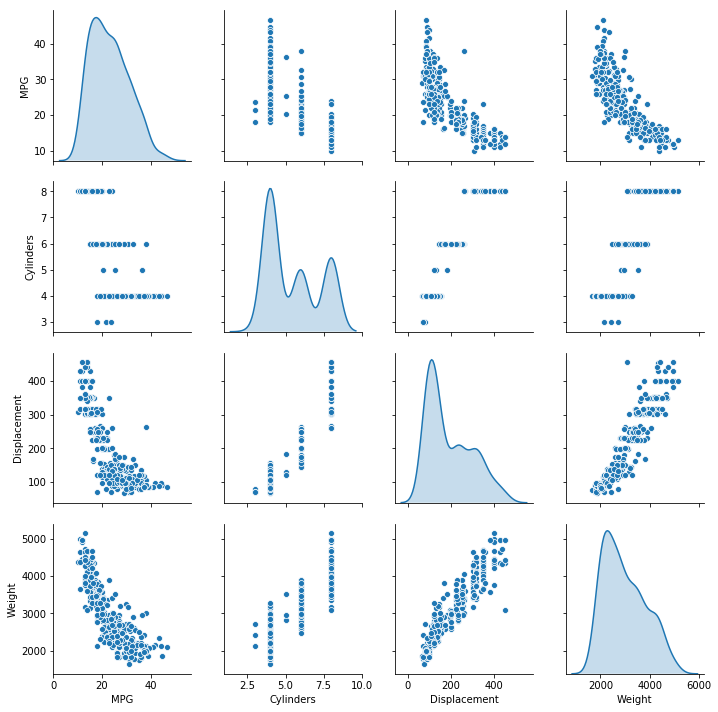

In [69]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind = "kde")

In [70]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [71]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [72]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [73]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [76]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [77]:
model = build_model()

In [78]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [79]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result
# The model seems to be predicting but needs to be trained

array([[ 0.12136739],
       [ 0.09759255],
       [ 0.2571832 ],
       [ 0.26810086],
       [-0.20251848],
       [ 0.05816411],
       [-0.21988605],
       [-0.04331996],
       [ 0.09128479],
       [-0.6674368 ]], dtype=float32)

In [80]:
EPOCHS = 1000
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log):
        if epoch%100 == 0:
            print('Epoch: {}'.format(epoch))
        print('.', end = '')
history = model.fit(normed_train_data, train_labels, epochs = EPOCHS, 
          validation_split = 0.2, verbose = 0, callbacks = [PrintDot()])

Epoch: 0
....................................................................................................Epoch: 100
....................................................................................................Epoch: 200
....................................................................................................Epoch: 300
....................................................................................................Epoch: 400
....................................................................................................Epoch: 500
....................................................................................................Epoch: 600
....................................................................................................Epoch: 700
....................................................................................................Epoch: 800
....................................................................................................Epo

In [81]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.483653,1.035888,2.483653,9.728052,2.390894,9.728051,995
996,2.297953,0.943824,2.297953,9.868288,2.415830,9.868288,996
997,2.333145,0.947192,2.333145,9.200386,2.288298,9.200386,997
998,2.334914,0.974102,2.334914,12.263237,2.763707,12.263238,998
999,2.336114,1.001070,2.336114,9.231655,2.286225,9.231654,999


In [ ]:
def plot_history(history):
    hist = pd.DataFtame()